In [1]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from matplotlib import rc
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from matplotlib.ticker import MaxNLocator
import scipy.signal
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

In [2]:
datapath = '/mnt/ssd/workspace/stability/MLstability/training_data/'
dset = 'resonant/'
features = 'orbsummaryfeaturesxgbNorbits10000.0Nout1729window10/'
dataset = pd.read_csv(datapath+dset+features+'trainingdata.csv', index_col = 0)
print(dataset.columns.values)

['t_final_short' 'avg_beta12' 'std_beta12' 'min_beta12' 'max_beta12'
 'avg_beta23' 'std_beta23' 'min_beta23' 'max_beta23' 'avg_a1' 'std_a1'
 'max_a1' 'min_a1' 'norm_std_a1' 'norm_max_a1' 'norm_std_window10_a1'
 'norm_max_window10_a1' 'avg_e1' 'std_e1' 'max_e1' 'min_e1' 'norm_std_e1'
 'norm_max_e1' 'norm_std_window10_e1' 'norm_max_window10_e1' 'avg_inc1'
 'std_inc1' 'max_inc1' 'min_inc1' 'norm_std_inc1' 'norm_max_inc1'
 'norm_std_window10_inc1' 'norm_max_window10_inc1' 'avg_eH1' 'std_eH1'
 'max_eH1' 'min_eH1' 'avg_iH1' 'std_iH1' 'max_iH1' 'min_iH1' 'avg_ecross1'
 'std_ecross1' 'max_ecross1' 'min_ecross1' 'norm_a1_slope' 'avg_a2'
 'std_a2' 'max_a2' 'min_a2' 'norm_std_a2' 'norm_max_a2'
 'norm_std_window10_a2' 'norm_max_window10_a2' 'avg_e2' 'std_e2' 'max_e2'
 'min_e2' 'norm_std_e2' 'norm_max_e2' 'norm_std_window10_e2'
 'norm_max_window10_e2' 'avg_inc2' 'std_inc2' 'max_inc2' 'min_inc2'
 'norm_std_inc2' 'norm_max_inc2' 'norm_std_window10_inc2'
 'norm_max_window10_inc2' 'avg_eH2' 'std_eH2' '

In [3]:
labels = pd.read_csv(datapath+dset+features+'labels.csv', index_col=0)
labels.tail()

,runstring,instability_time,shadow_instability_time,Stable
9994,0009995.bin,9.990000e+08,9.990000e+08,True
9995,0009996.bin,3.814426e+06,6.124299e+06,False
9996,0009997.bin,1.498363e+04,3.320307e+03,False
9997,0009998.bin,9.419807e+05,8.353625e+05,False
9998,0009999.bin,1.895071e+07,2.047024e+07,False


In [4]:
features = []
features += ['avg_iH1', 'avg_iH2']
features += ['norm_std_a1', 'norm_max_a1', 'norm_std_window10_a1', 'norm_max_window10_a1']
features += ['norm_std_a2', 'norm_max_a2', 'norm_std_window10_a2', 'norm_max_window10_a2']
features += ['norm_std_a3', 'norm_max_a3', 'norm_std_window10_a3', 'norm_max_window10_a3']
features += ['avg_ecross1', 'std_ecross1', 'max_ecross1', 'min_ecross1']
features += ['avg_ecross2', 'std_ecross2', 'max_ecross2', 'min_ecross2']
features += ['avg_ecross3', 'std_ecross3', 'max_ecross3', 'min_ecross3']
features += ['norm_a1_slope', 'norm_a2_slope', 'norm_a3_slope']
features += ['avg_beta12','std_beta12','min_beta12','max_beta12','avg_beta23','std_beta23','min_beta23','max_beta23'] 
y = labels['Stable']
X = dataset[features]
X.head()

,avg_iH1,avg_iH2,norm_std_a1,norm_max_a1,norm_std_window10_a1,norm_max_window10_a1,norm_std_a2,norm_max_a2,norm_std_window10_a2,norm_max_window10_a2,...,norm_a2_slope,norm_a3_slope,avg_beta12,std_beta12,min_beta12,max_beta12,avg_beta23,std_beta23,min_beta23,max_beta23
0,0.469435,0.305854,0.000015,0.000054,0.000010,0.000019,0.000011,0.000064,0.000010,0.000024,...,3.089428e-15,-4.976292e-13,28.595493,0.001891,28.588882,28.602909,3.701040,0.034242,3.516690,3.746651
1,3.308394,1.733069,0.000077,0.000330,0.000031,0.000047,0.000032,0.000090,0.000040,0.000066,...,-2.352427e-14,4.173968e-13,13.483132,0.005865,13.457207,13.494161,4.539888,0.052836,4.401421,4.621762
2,0.544804,0.283368,0.000347,0.001713,0.000049,0.000093,0.000027,0.000082,0.000026,0.000057,...,2.228449e-15,-6.754759e-16,5.870284,0.017904,5.781815,5.894776,28.628436,0.001935,28.622629,28.631553
3,1.549076,1.982465,0.000048,0.000111,0.000014,0.000028,0.000452,0.000954,0.000148,0.000244,...,-4.961098e-14,-5.312319e-15,15.489837,0.026805,15.437264,15.546207,21.681183,0.032839,21.610798,21.748419
4,3.658147,1.392162,0.000194,0.000734,0.000120,0.000166,0.000337,0.001610,0.000508,0.001216,...,-2.209706e-13,2.436526e-14,5.324567,0.038396,5.182953,5.505743,10.280700,0.017128,10.200173,10.344261


In [5]:
X.shape

(9999, 37)

In [6]:
Nrows = int(0.8*X.shape[0])
trainX = X.iloc[:Nrows, :]
trainY = y.iloc[:Nrows]
testX = X.iloc[Nrows:, :]
testY = y.iloc[Nrows:]
xgbc = XGBClassifier(seed = 0)

In [7]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

In [8]:
space ={
        'max_depth': hp.randint('x_max_depth',  20),
        'min_child_weight': hp.quniform ('x_min_child', 1, 10, 1),
        'subsample': hp.uniform ('x_subsample', 0.8, 1),
        'scale_pos_weight': hp.uniform("x_pos_weight", 1, 15),
        "learning_rate":hp.uniform("x_learning_rate",0.01,0.2),
        'colsample_bytree': hp.uniform ('x_tree_colsample', 0.5,1),
}

dtrain = xgb.DMatrix(trainX, trainY)
dtest = xgb.DMatrix(testX, testY)
def objective(space):

    clf = XGBClassifier(n_estimators = 100, 
                            max_depth = space['max_depth'], 
                            min_child_weight =space['min_child_weight'],
                            subsample = space['subsample'],
                            colsample_bytree =space['colsample_bytree'],
                            learning_rate = space['learning_rate'], seed = 0)
    
    params = clf.get_xgb_params()
    #dtest
    score = xgb.cv(params, dtrain, nfold = 5, metrics = "auc", early_stopping_rounds=10)
    #print score
    #score = cross_val_score(clf, trainX, trainY, cv = 5, scoring="average_precision")
    avg_score =  np.mean(score["test-auc-mean"])
    error = np.mean(score["test-auc-std"])
    
    bst = xgb.train(params, dtrain)
    preds = bst.predict(dtest)
    test_score = metrics.roc_auc_score(testY, preds)
    
    print("SCORE:", avg_score, "ERROR", error, "HOLDOUT SCORE", test_score)

    return{'loss':1-test_score, 'status': STATUS_OK, "cv_score":avg_score , "cv_error":error, "holdout":test_score }

/home/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [9]:
%%time
trials = Trials()
import time
start = time.time()
best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 50, trials = trials)
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

SCORE:                                              
0.87094034                                          
ERROR                                               
0.0061418941284072225                               
HOLDOUT SCORE                                       
0.8883708614641229                                  
SCORE:                                                                        
0.87515164                                                                    
ERROR                                                                         
0.0055725125403871                                                            
HOLDOUT SCORE                                                                 
0.8970593638313533                                                            
SCORE:                                                                        
0.89414096                                                                    
ERROR                                             

0.0042425098296350145                                                          
HOLDOUT SCORE                                                                  
0.9133449213815961                                                             
SCORE:                                                                         
0.8970907800000001                                                             
ERROR                                                                          
0.004943479856360239                                                           
HOLDOUT SCORE                                                                  
0.9133138819666067                                                             
SCORE:                                                                         
0.89616998                                                                     
ERROR                                                                          
0.004896125963592283                    

0.004321155300609599                                                           
HOLDOUT SCORE                                                                  
0.8991174670823836                                                             
SCORE:                                                                         
0.8961835200000001                                                             
ERROR                                                                          
0.0029395553531659747                                                          
HOLDOUT SCORE                                                                  
0.9174484587346813                                                             
SCORE:                                                                         
0.8880117000000001                                                             
ERROR                                                                          
0.005327267683644722                    

In [10]:
#fit the smaller rage 
#{'x_learning_rate': 0.07419653015127085,
# 'x_max_depth': 8,
# 'x_min_child': 4.0,
# 'x_pos_weight': 8.889472764333366,
# 'x_subsample': 0.9380315392096068,
# 'x_tree_colsample': 0.734517699234413}

#{'x_learning_rate': 0.19890696372714528,
# 'x_max_depth': 17,
# 'x_min_child': 8.0,
# 'x_pos_weight': 12.505309968632893,
# 'x_subsample': 0.9409498631912948,
# 'x_tree_colsample': 0.7528946858805113}

best

{'x_learning_rate': 0.15017661107275806,
 'x_max_depth': 14,
 'x_min_child': 3.0,
 'x_pos_weight': 2.765652850203342,
 'x_subsample': 0.9953929786250463,
 'x_tree_colsample': 0.8615349149691718}

In [11]:
best_xgbc = XGBClassifier(n_estimators=100, scale_pos_weight=best["x_pos_weight"],
                         learning_rate = best["x_learning_rate"], 
                         max_depth = int(best["x_max_depth"]), 
                         min_child_weight = best["x_min_child"],
                         subsample = best["x_subsample"], 
                         colsample_bytree = best["x_tree_colsample"])
params = best_xgbc.get_xgb_params()
score = xgb.cv(params, dtrain, nfold = 5, metrics = "auc", verbose_eval=True)
print(score)
d_Train = xgb.DMatrix(trainX, trainY)
d_Test = xgb.DMatrix(testX)
bst = xgb.train(params, d_Train)
preds = bst.predict(d_Test)
score = metrics.average_precision_score(testY, preds)
print(score)

[0]	train-auc:0.965666+0.00235213	test-auc:0.859329+0.00820682
[1]	train-auc:0.982627+0.000412983	test-auc:0.882687+0.00681484
[2]	train-auc:0.988889+0.000521374	test-auc:0.891318+0.00432083
[3]	train-auc:0.992258+0.000689254	test-auc:0.898819+0.00449925
[4]	train-auc:0.994085+0.000762465	test-auc:0.905251+0.0044145
[5]	train-auc:0.99539+0.000622642	test-auc:0.907305+0.00489513
[6]	train-auc:0.996528+0.000397224	test-auc:0.908988+0.00539245
[7]	train-auc:0.997299+0.000336775	test-auc:0.910496+0.00617793
[8]	train-auc:0.997893+0.000254037	test-auc:0.911485+0.00618334
[9]	train-auc:0.998322+0.000160406	test-auc:0.9128+0.00637553
   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0        0.965666       0.002352       0.859329      0.008207
1        0.982627       0.000413       0.882687      0.006815
2        0.988889       0.000521       0.891318      0.004321
3        0.992258       0.000689       0.898819      0.004499
4        0.994085       0.000762       0.905251      0.

/home/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


0.8052924605884674


In [12]:
#try testing on the holdout set with these parameters
from sklearn.metrics import roc_auc_score

    
best_xgbc = XGBClassifier(n_estimators=100, scale_pos_weight=best["x_pos_weight"],
                         learning_rate = best["x_learning_rate"], 
                         max_depth = int(best["x_max_depth"]), 
                         min_child_weight = best["x_min_child"],
                         subsample = best["x_subsample"], 
                         colsample_bytree = best["x_tree_colsample"])

best_xgbc.fit(trainX, trainY)
preds = best_xgbc.predict_proba(testX)[:,1]
auc_Score = roc_auc_score(testY,preds)
print(auc_Score)
print(metrics.average_precision_score(testY, preds))

0.9328535104311438
0.8493864344622264


In [13]:
print(best)

{'x_learning_rate': 0.15017661107275806, 'x_max_depth': 14, 'x_min_child': 3.0, 'x_pos_weight': 2.765652850203342, 'x_subsample': 0.9953929786250463, 'x_tree_colsample': 0.8615349149691718}


Text(0.5, 1.0, 'ROC curve (AUC = 0.933)')

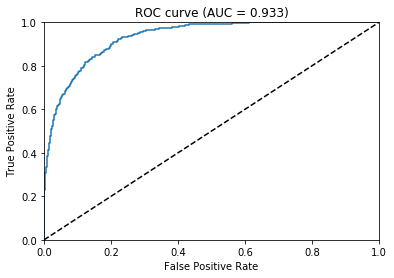

In [14]:
#the ROCAUC score is now 98.0 witht eh 2080 split compared to the 40 60 from before 
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(testY, preds)
fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(metrics.roc_auc_score(testY, preds)))

In [15]:
precision, recall, thresholds = sklearn.metrics.precision_recall_curve(testY, preds)
for i in range(0,len(recall), 15):
    print("Threshold {0}, recall = {1}, precision = {2}".format(thresholds[i], recall[i], precision[i]))

Threshold 0.0014949454925954342, recall = 1.0, precision = 0.3772663877266388
Threshold 0.0016297711990773678, recall = 0.9981515711645101, precision = 0.38054968287526425
Threshold 0.0018020544666796923, recall = 0.9981515711645101, precision = 0.38461538461538464
Threshold 0.0020008464343845844, recall = 0.9981515711645101, precision = 0.38876889848812096
Threshold 0.0021681252401322126, recall = 0.9963031423290203, precision = 0.3922852983988355
Threshold 0.002317463280633092, recall = 0.9944547134935305, precision = 0.3958793230316409
Threshold 0.0024868312757462263, recall = 0.9944547134935305, precision = 0.40029761904761907
Threshold 0.002655110554769635, recall = 0.9944547134935305, precision = 0.40481565086531224
Threshold 0.0028857546858489513, recall = 0.9944547134935305, precision = 0.4094368340943683
Threshold 0.003119170432910323, recall = 0.9926062846580407, precision = 0.4133949191685912
Threshold 0.0033007494639605284, recall = 0.9926062846580407, precision = 0.4182242

AUC Score (Test): 0.849386


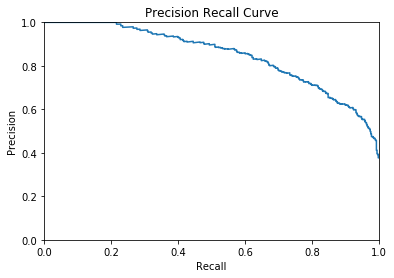

In [16]:
#draw precison recall curve
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(testY, preds)
fig, ax = plt.subplots()
ax.plot(recall, precision)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision Recall Curve')
print("AUC Score (Test): %f" % metrics.average_precision_score(testY, preds))
plt.show()

[0.99282926 0.9912401  0.9786119  0.40886462 0.07960986]
541 1459
[960. 101.  45.  32.  21.  18.  16.  15.   8.  16.  13.   8.  11.   9.
   7.   5.   7.   6.   4.   5.   5.   8.   6.   1.   5.   5.   7.   4.
   5.   6.   5.   5.   3.   8.   4.   4.   2.   3.   6.   5.   4.   8.
   2.   3.   6.   6.   3.   8.   5.  10.]
[16 12  9  6 10 11  5  6  6  1  4  5  5  2  4  6  5  1  7  2  5  2  4  6
  2  2 10  3  5  4  3  8  1  3  7  9  3  3  3  6 13  8 12  9 11 20 22 21
 37 59]


(0, 350)

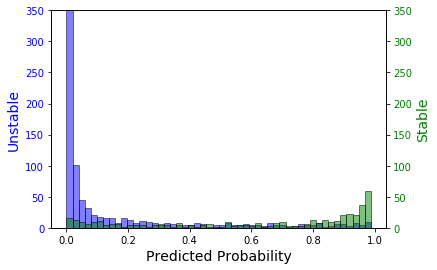

In [17]:
# Histogram:
bins = 50
Stable=preds[np.where(testY==1)]
print(Stable[:5][:])
Unstable=preds[np.where(testY==0)]
print(Stable.size, Unstable.size)


fig, ax1 = plt.subplots()
n, bins, pathces = ax1.hist(Unstable, bins, alpha=0.5, label='No', color='blue', edgecolor = "black")
print(n)
ax1.set_xlabel('Predicted Probability', fontsize=14)
ax1.set_ylabel('Unstable',  fontsize=14, color='blue')
for tl in ax1.get_yticklabels():
    tl.set_color('blue')
    


ax2 = ax1.twinx()
n, bins , patches = ax2.hist(Stable, bins, alpha=0.5, label='Yes',color='green', edgecolor = "black")
print(n.astype(int))
ax2.set_ylabel('Stable', fontsize=14, color='green')
for tl in ax2.get_yticklabels():
    tl.set_color('green')
    
    
#ax1.set_ylim(ax2.get_ylim())
ax1.set_ylim([0,350]) # goes up to ~4300
ax2.set_ylim([0,350]) # goes up to ~2100

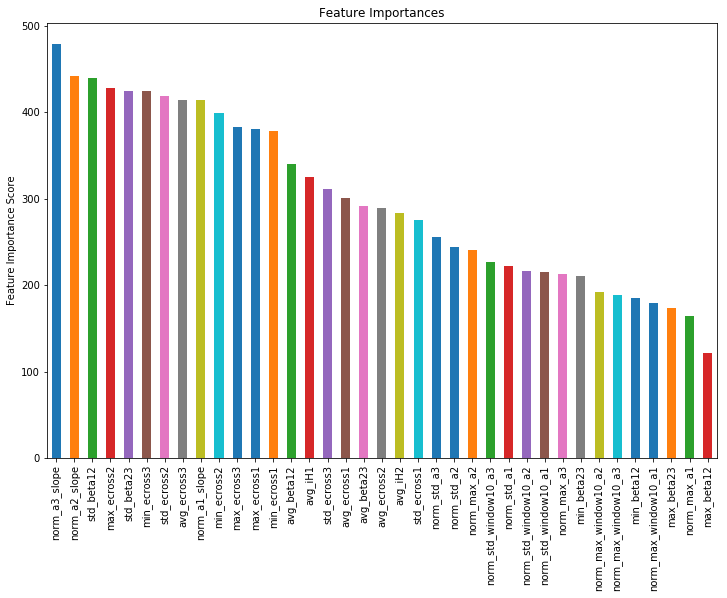

In [18]:
# feature importances
feat_imp = pd.Series(best_xgbc.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(12,8))
plt.ylabel('Feature Importance Score')
plt.show()

In [19]:
import dill
import sys
dill.dump([best_xgbc, features], open(datapath+"../models/orbsummaryfeaturesxgb_resonant.pkl", "wb"))